# GEONE - Gaussian Random Fields (GRF) based on FFT - Examples in 1D

Generate gaussian random fields (GRF) following a method based on (block) circulant embedding of the covariance matrix and Fast Fourier Transform (FFT) (to compute discrete Fourier Transform): functions `geone.grf.grf<d>D` and `geone.grf.krige<d>D`.

### References

- J\. W\. Cooley, J\. W\. Tukey (1965) An algorithm for machine calculation of complex Fourier series. Mathematics of Computation 19(90):297-301, [doi:10.2307/2003354](https://dx.doi.org/10.2307/2003354)
- C\. R\. Dietrich, G. N. Newsam (1993) A fast and exact method for multidimensional gaussian stochastic simulations. Water Resources Research 29(8):2861-2869, [doi:10.1029/93WR01070](https://dx.doi.org/10.1029/93WR01070)
- A\. T\. A\. Wood, G. Chan (1994) Simulation of Stationary Gaussian Processes in :math:`[0, 1]^d`. Journal of Computational and Graphical Statistics 3(4):409-432, [doi:10.2307/1390903](https://dx.doi.org/10.2307/1390903)

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


### Remark
The matplotlib figures can be visualized in *interactive* mode:

- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Covariance model in 1D: class `geone.covModel.covModel1D`

A covariance model is defined by its elementary contributions given as a list of 2-tuples, 
whose the first component is the type given by a string (`nugget`, `spherical`, `exponential`, `gaussian`, ...) and the second component is a dictionary used to pass the required parameters (the weight (`w`), the range (`r`), ...).

*Note: see the notebook `ex_general_multiGaussian.ipynb` for available covariance models and examples.*

In [3]:
cov_model = gn.covModel.CovModel1D(elem=[
    ('gaussian', {'w':4.9, 'r':100}), # elementary contribution
    ('nugget', {'w':.1})             # elementary contribution
    ], name='model-1D example')

In [4]:
cov_model

*** CovModel1D object ***
name = 'model-1D example'
number of elementary contribution(s): 2
elementary contribution 0
    type: gaussian
    parameters:
        w = 4.9
        r = 100
elementary contribution 1
    type: nugget
    parameters:
        w = 0.1
*****

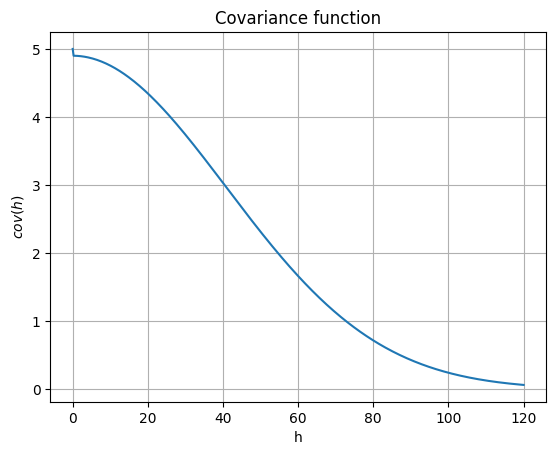

In [5]:
plt.figure()
cov_model.plot_model()
plt.title('Covariance function')
plt.show()

## GRFs - simulation and estimation in 1D
The following functions are used:

- `geone.grf.grf1D` for simulation 1D
- `geone.grf.krige1D` for estimation 1D

The algorithms are based on Fast Fourier Transform (FFT), then periodic fields are generated (for simulation / estimation). Hence, an extended simulation grid is used and then cropped after the simulation. The extension should be large enough in order to avoid wrong correlations, i.e. correlations across opposite borders of the grid, or correlations between two nodes regarding both distances between them (with respect to the periodic grid).

An appropriate extension is automatically computed by the function `geone.grf.grf1D` based on the covariance model class passed as first argument. However, the minimal extension can be given explicitly with the keyword argument `extensionMin`.

Note that a covariance function can be passed as first argument (e.g. the function `cov_model.func()` instead of the class `cov_model`). In this situation, an appropriate minimal extension can be computed by the function `extension_min` (i.e. `extension_min(cov_model.r(), nx, sx)`), and then passed to the GRF simulator `geone.grf.grf1D` via the keyword argument `extensionMin`.

*Notes.*
When passing the covariance model class as first argument, the extension is computed based on the range of the covariance. If the results show artefacts or unexpected features (this can happen when using Gaussian covariance model), one may try to fix the problem by increasing the extension. To do so, a factor (greather than one) can be specified via the keyword argument `rangeFactorForExtensionMin`: the range will be multiplied by this factor before computing the extension.

*Remark:* the keyword argument `verbose` allows to control what is displayed, `verbose=0`: minimal display, `verbose=1`: only error(s) (if any), `verbose=2` (default): error(s) and warning(s) encountered, `verbose=3`: error(s) and warning(s) encountered, and additional information.

### Data aggregation in grid
As the simulation / estimation is done in a grid, the conditioning data are first aggregated in the grid cells, i.e. data points falling in the same grid cell are aggregated in one unique value at the cell centre, using the operation specified by the parameter (keyword argument) `aggregate_data_op`, a string that can be `'sgs'` (i.e. function `geone.covModel.sgs` is used, for simulation only), `'krige'` (i.e. function `geone.covModel.krige` is used, default for estimation), `'min'`, `'max'`, `'mean'` (i.e. function `numpy.<aggregate_data_op>` is used), etc. Furthermore, the parameter (keyword argument) `aggregate_data_op_kwargs` is a dictionary that contains keyword arguments passed to the operation specified by `aggregate_data_op`.

If `aggregate_data_op='krige'` or `aggregate_data_op='sgs'` is specified, a covariance model (not directly a covariance function) has to be passed as first argument. 

*Note:* for simulation, by specifiying `aggregate_data_op='sgs'` (default), the aggregation is done for each realization (simulation), i.e. each simulation in the grid starts with a new set of values in conditioning grid cells.

### Alternative: wrapper `geone.multiGaussian.multiGaussianRun`

The function `geone.multiGaussian.multiGaussianRun` can be used as a wrapper; with keyword arguments:

- `mode='simulation', algo='fft'`: wrapper for `geone.grf.grf<d>D`
- `mode='estimation', algo='fft'`: wrapper for `geone.grf.krige<d>D`

where the dimension `<d>` is automatically detected. Note also that the function `geone.multiGaussian.multiGaussianRun` allows to choose the "format" of the output by the keyword argument `output_mode`:

- `output_mode='array'`: an numpy array is returned
- `output_mode='img'`: an "image" (class `geone.img.Img`) is returned

## GRFs - 1D
Define the simulation grid.

In [6]:
nx = 1000 # number of cells
sx = 0.5  # cell unit
ox = 0.0  # origin

## Case A - Unconditional 

### Simulation - case A
Set the number of realizations, the seed and launch the (unconditional) simulations.

In [7]:
nreal = 10000
np.random.seed(123)
t1 = time.time() # start time
sim1Da = gn.grf.grf1D(cov_model, nx, sx, ox, nreal=nreal)
# sim1Da = gn.grf.grf1D(cov_model, nx, sx, ox, nreal=nreal, verbose=3)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

Elapsed time: 0.51 sec


In [8]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
t1 = time.time() # start time
np.random.seed(123)
out = gn.multiGaussian.multiGaussianRun(cov_model, nx, sx, ox, 
                                        mode='simulation', algo='fft', output_mode='array',
                                        nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, sim1Da)}') # should be True

grf1D: Preliminary computation...
grf1D: Computing circulant embedding...
grf1D: embedding dimension: 2048
grf1D: Computing FFT of circulant matrix...
Elapsed time: 0.51 sec
Same results ? True


The result is a 2d array of size `nreal` by `nx`:

In [9]:
sim1Da.shape

(10000, 1000)

Compute the mean and the standard deviation over the realizations (pixel-wise).

In [10]:
sim1Da_mean = np.mean(sim1Da, axis=0)
sim1Da_std = np.std(sim1Da, axis=0)

### Kriging - case A
Compute (simple) kriging estimates and standard deviation.

*Note: not really interesting here, without any data.*

In [11]:
t1 = time.time() # start time
krig1Da, krig1Da_std = gn.grf.krige1D(cov_model, nx, sx, ox)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

Elapsed time: 0.00016 sec


In [12]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
t1 = time.time() # start time
np.random.seed(123)
out = gn.multiGaussian.multiGaussianRun(cov_model, nx, sx, ox, 
                                        mode='estimation', algo='fft', output_mode='array')
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, np.array((krig1Da, krig1Da_std)))}') # should be True

Elapsed time: 0.0006 sec
Same results ? True


In [13]:
krig1Da.shape, krig1Da_std.shape

((1000,), (1000,))

### Plot results - case A

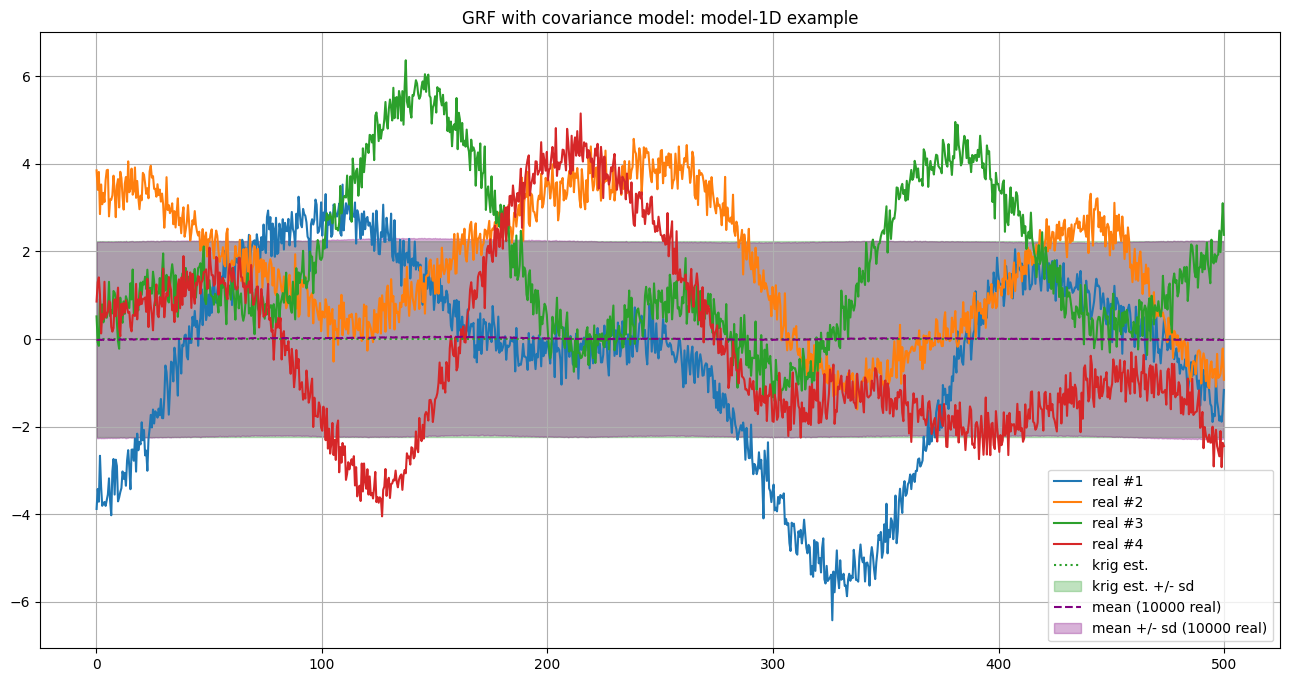

In [14]:
xg = ox + sx*(0.5+np.arange(nx)) # center of grid cells

plt.figure(figsize=(16,8))

for i in range(4):
    plt.plot(xg, sim1Da[i], label=f'real #{i+1}')

plt.plot(xg, krig1Da, c='tab:green', ls='dotted', label=f'krig est.')
plt.fill_between(xg, krig1Da - krig1Da_std, krig1Da + krig1Da_std, 
                 color='tab:green', alpha=.3, label='krig est. +/- sd')

plt.plot(xg, sim1Da_mean, c='purple', ls='dashed', label=f'mean ({nreal} real)')
plt.fill_between(xg, sim1Da_mean - sim1Da_std, sim1Da_mean + sim1Da_std, 
                 color='purple', alpha=.3, label=f'mean +/- sd ({nreal} real)')
plt.grid()
plt.legend()
plt.title('GRF with covariance model: {}'.format(cov_model.name))
plt.show()

## Case B - Conditional
Define (hard) data.

In [15]:
x = [10.1, 50.25, 238.5, 384.3]  # data locations (real coordinates)
v = [-3.2,  1.2,   4.7,  -2.0]   # data values

### Simulation - case B
Set the number of realizations, the seed and launch the simulations.

In [16]:
nreal = 10000
np.random.seed(123)
t1 = time.time() # start time
sim1Db = gn.grf.grf1D(cov_model, nx, sx, ox, x=x, v=v, nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Compute the mean and the standard deviation over the realizations (pixel-wise).
sim1Db_mean = np.mean(sim1Db, axis=0)
sim1Db_std = np.std(sim1Db, axis=0)

Elapsed time: 2.7 sec


In [17]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
np.random.seed(123)
t1 = time.time() # start time
out = gn.multiGaussian.multiGaussianRun(cov_model, nx, sx, ox, 
                                        x=x, v=v, 
                                        mode='simulation', algo='fft', output_mode='array',
                                        nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, sim1Db)}') # should be True

grf1D: Preliminary computation...
grf1D: Computing circulant embedding...
grf1D: embedding dimension: 2048
grf1D: Computing FFT of circulant matrix...
grf1D: Treatment of conditioning data...
grf1D: Computing covariance matrix (rAA) for conditioning locations...
grf1D: Computing index in the embedding grid for non-conditioning / conditioning locations...
Elapsed time: 2.5 sec
Same results ? True


### Kriging - case B
Compute (simple) kriging estimates and standard deviation.

In [18]:
t1 = time.time() # start time
krig1Db, krig1Db_std = gn.grf.krige1D(cov_model, nx, sx, ox, x=x, v=v)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

Elapsed time: 0.0061 sec


In [19]:
# %%script false --no-raise-error # skip this cell! (comment  this line to run the cell)

# Alternative:
np.random.seed(123)
t1 = time.time() # start time
out = gn.multiGaussian.multiGaussianRun(cov_model, nx, sx, ox, 
                                        x=x, v=v, 
                                        mode='estimation', algo='fft', output_mode='array')
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, np.array((krig1Db, krig1Db_std)))}') # should be True

krige1D: Computing circulant embedding...
krige1D: embedding dimension: 2048
krige1D: Computing FFT of circulant matrix...
krige1D: Computing covariance matrix (rAA) for conditioning locations...
krige1D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
krige1D: Computing rBA * rAA^(-1)...
krige1D: computing kriging estimates...
krige1D: computing kriging standard deviation ...
Elapsed time: 0.0029 sec
Same results ? True


### Plot results - case B

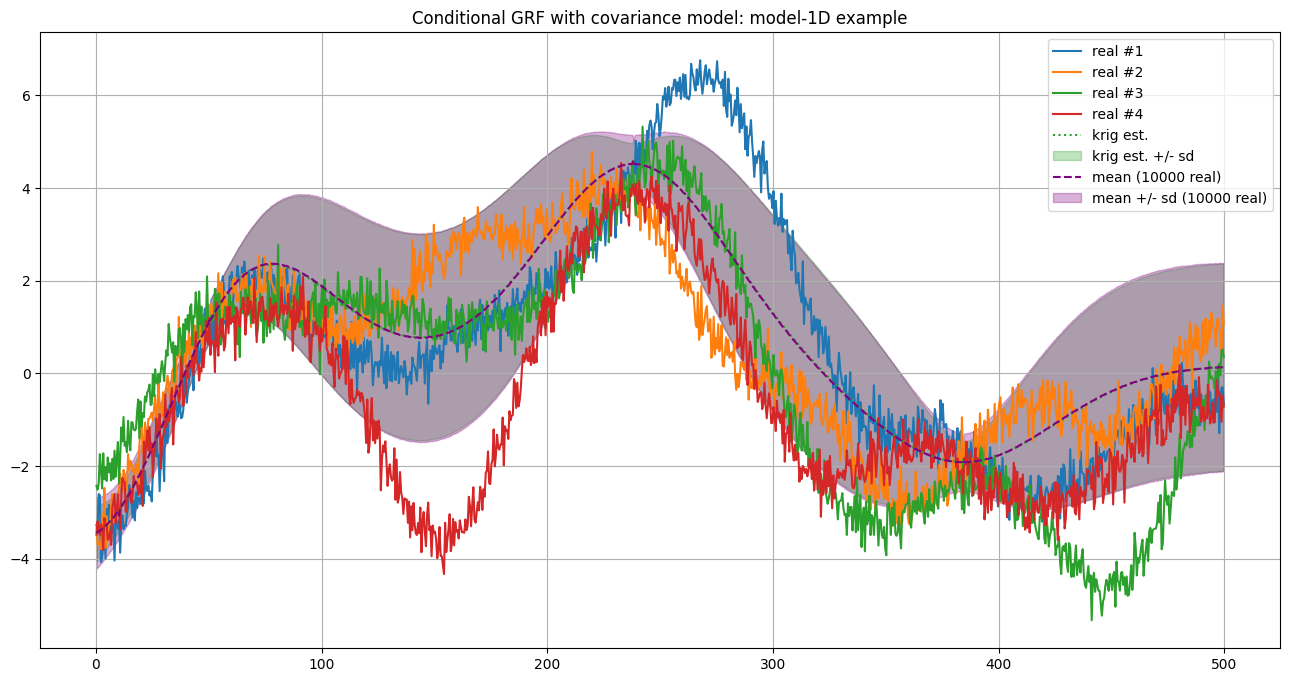

In [20]:
xg = ox + sx*(0.5+np.arange(nx)) # center of grid cells

plt.figure(figsize=(16,8))

for i in range(4):
    plt.plot(xg, sim1Db[i], label=f'real #{i+1}')

plt.plot(xg, krig1Db, c='tab:green', ls='dotted', label=f'krig est.')
plt.fill_between(xg, krig1Db - krig1Db_std, krig1Db + krig1Db_std, 
                 color='tab:green', alpha=.3, label='krig est. +/- sd')

plt.plot(xg, sim1Db_mean, c='purple', ls='dashed', label=f'mean ({nreal} real)')
plt.fill_between(xg, sim1Db_mean - sim1Db_std, sim1Db_mean + sim1Db_std, 
                 color='purple', alpha=.3, label=f'mean +/- sd ({nreal} real)')
plt.grid()
plt.legend()
plt.title('Conditional GRF with covariance model: {}'.format(cov_model.name))
plt.show()


## Imposing mean and/or variance
Mean and variance in the simulation grid can be specified, they can be stationary (constant) or non-stationary. 
By default, the mean is set to the mean of data values (or zero if no conditioning data) (constant) and the variance is given by the sill of the variogram model (constant).



## Case C - Constant mean and variance
Set mean to $3.0$ and variance to the double of the covariance model sill. (Use the same data as above.)

### Simulation - case C
Set the number of realizations, the seed and launch the simulations.

In [21]:
nreal = 10000
np.random.seed(123)
t1 = time.time() # start time
sim1Dc = gn.grf.grf1D(cov_model, nx, sx, ox, x=x, v=v, 
                      mean=3., var=2*cov_model.sill(), nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Compute the mean and the standard deviation over the realizations (pixel-wise).
sim1Dc_mean = np.mean(sim1Dc, axis=0)
sim1Dc_std = np.std(sim1Dc, axis=0)

Elapsed time: 2.6 sec


In [22]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
np.random.seed(123)
t1 = time.time() # start time
out = gn.multiGaussian.multiGaussianRun(cov_model, nx, sx, ox, 
                                        x=x, v=v, 
                                        mean=3., var=2*cov_model.sill(),
                                        mode='simulation', algo='fft', output_mode='array',
                                        nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, sim1Dc)}') # should be True

grf1D: Preliminary computation...
grf1D: Computing circulant embedding...
grf1D: embedding dimension: 2048
grf1D: Computing FFT of circulant matrix...
grf1D: Treatment of conditioning data...
grf1D: Computing covariance matrix (rAA) for conditioning locations...
grf1D: Computing index in the embedding grid for non-conditioning / conditioning locations...
Elapsed time: 2.6 sec
Same results ? True


### Kriging - case C
Compute (simple) kriging estimates and standard deviation.

In [23]:
t1 = time.time() # start time
krig1Dc, krig1Dc_std = gn.grf.krige1D(cov_model, nx, sx, ox, x=x, v=v, mean=3., var=2*cov_model.sill())
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

Elapsed time: 0.0024 sec


In [24]:
# %%script false --no-raise-error # skip this cell! (comment  this line to run the cell)

# Alternative:
np.random.seed(123)
t1 = time.time() # start time
out = gn.multiGaussian.multiGaussianRun(cov_model, nx, sx, ox, 
                                        x=x, v=v, 
                                        mean=3., var=2*cov_model.sill(),
                                        mode='estimation', algo='fft', output_mode='array')
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, np.array((krig1Dc, krig1Dc_std)))}') # should be True

krige1D: Computing circulant embedding...
krige1D: embedding dimension: 2048
krige1D: Computing FFT of circulant matrix...
krige1D: Computing covariance matrix (rAA) for conditioning locations...
krige1D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
krige1D: Computing rBA * rAA^(-1)...
krige1D: computing kriging estimates...
krige1D: computing kriging standard deviation ...
Elapsed time: 0.0043 sec
Same results ? True


### Plot results - case C

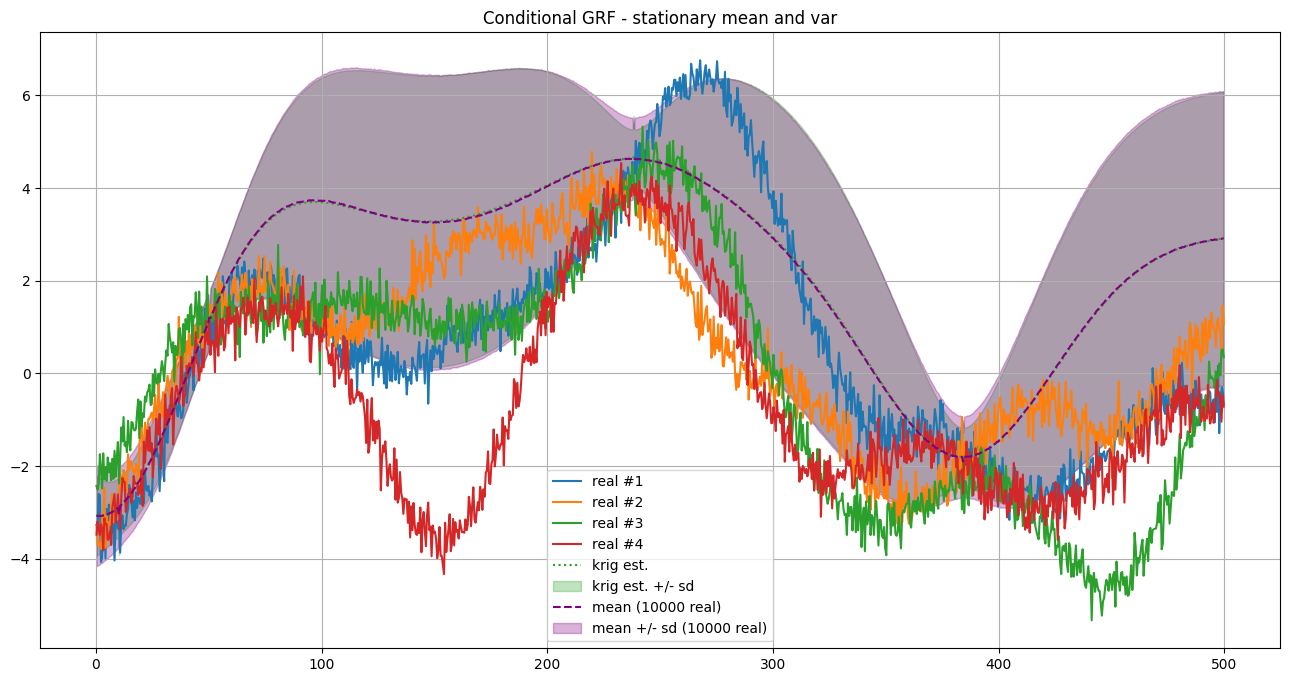

In [25]:
xg = ox + sx*(0.5+np.arange(nx)) # center of grid cells

plt.figure(figsize=(16,8))

for i in range(4):
    plt.plot(xg, sim1Db[i], label=f'real #{i+1}')

plt.plot(xg, krig1Dc, c='tab:green', ls='dotted', label=f'krig est.')
plt.fill_between(xg, krig1Dc - krig1Dc_std, krig1Dc + krig1Dc_std, 
                 color='tab:green', alpha=.3, label='krig est. +/- sd')

plt.plot(xg, sim1Dc_mean, c='purple', ls='dashed', label=f'mean ({nreal} real)')
plt.fill_between(xg, sim1Dc_mean - sim1Dc_std, sim1Dc_mean + sim1Dc_std, 
                 color='purple', alpha=.3, label=f'mean +/- sd ({nreal} real)')
plt.grid()
plt.legend()
plt.title('Conditional GRF - stationary mean and var')
plt.show()



## Case D - Non-stationary mean and variance
Set the mean varying linearly from $-10.0$ (at the left border) to $+10.0$ (at the right border), and the variance
from $0.1$ to $4.0$. (Use the same data as above.)

In [26]:
# Set mean and variance
mean = np.linspace(-10, 10, nx)
var = np.linspace(0.1, 4, nx)*cov_model.sill()


### Simulation - case C
Set the number of realizations, the seed and launch the simulations.

In [27]:
# Simulation
nreal = 10000
np.random.seed(123)
t1 = time.time() # start time
sim1Dd = gn.grf.grf1D(cov_model, nx, sx, ox, x=x, v=v, mean=mean, var=var, nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Compute the mean and the standard deviation over the realizations (pixel-wise).
sim1Dd_mean = np.mean(sim1Dd, axis=0)
sim1Dd_std = np.std(sim1Dd, axis=0)

Elapsed time: 2.7 sec


In [28]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
np.random.seed(123)
t1 = time.time() # start time
out = gn.multiGaussian.multiGaussianRun(cov_model, nx, sx, ox, 
                                        x=x, v=v, 
                                        mean=mean, var=var,
                                        mode='simulation', algo='fft', output_mode='array',
                                        nreal=nreal)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, sim1Dd)}') # should be True

grf1D: Preliminary computation...
grf1D: Computing circulant embedding...
grf1D: embedding dimension: 2048
grf1D: Computing FFT of circulant matrix...
grf1D: Treatment of conditioning data...
grf1D: Computing covariance matrix (rAA) for conditioning locations...
grf1D: Computing index in the embedding grid for non-conditioning / conditioning locations...
Elapsed time: 3 sec
Same results ? True


### Kriging - case D
Compute (simple) kriging estimates and standard deviation.

In [29]:
t1 = time.time() # start time
krig1Dd, krig1Dd_std = gn.grf.krige1D(cov_model, nx, sx, ox, x=x, v=v, mean=mean, var=var)
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

Elapsed time: 0.0042 sec


In [30]:
# %%script false --no-raise-error # skip this cell! (comment  this line to run the cell)

# Alternative:
np.random.seed(123)
t1 = time.time() # start time
out = gn.multiGaussian.multiGaussianRun(cov_model, nx, sx, ox, 
                                        x=x, v=v, 
                                        mean=mean, var=var,
                                        mode='estimation', algo='fft', output_mode='array')
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

# Same results:
print(f'Same results ? {np.allclose(out, np.array((krig1Dd, krig1Dd_std)))}') # should be True

krige1D: Computing circulant embedding...
krige1D: embedding dimension: 2048
krige1D: Computing FFT of circulant matrix...
krige1D: Computing covariance matrix (rAA) for conditioning locations...
krige1D: Computing covariance matrix (rBA) for non-conditioning / conditioning locations...
krige1D: Computing rBA * rAA^(-1)...
krige1D: computing kriging estimates...
krige1D: computing kriging standard deviation ...
Elapsed time: 0.0048 sec
Same results ? True


### Plot results - case D

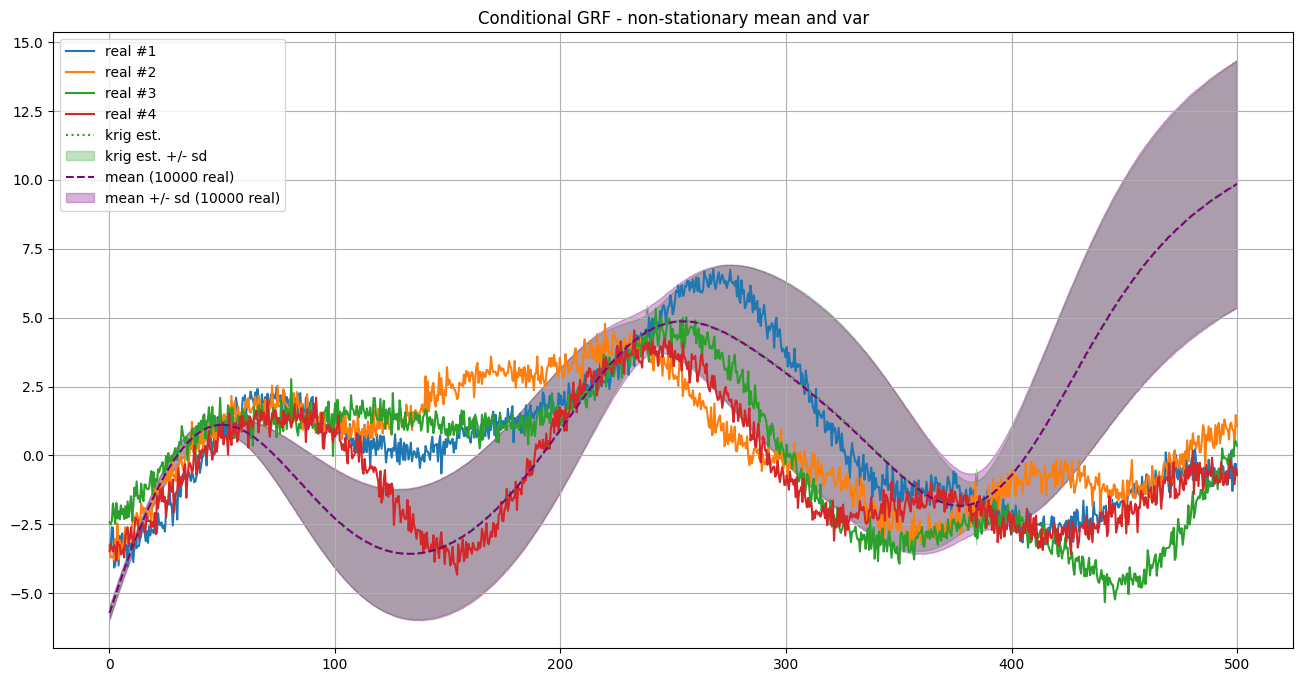

In [31]:
xg = ox + sx*(0.5+np.arange(nx)) # center of grid cells

plt.figure(figsize=(16,8))

for i in range(4):
    plt.plot(xg, sim1Db[i], label=f'real #{i+1}')

plt.plot(xg, krig1Dd, c='tab:green', ls='dotted', label=f'krig est.')
plt.fill_between(xg, krig1Dd - krig1Dd_std, krig1Dd + krig1Dd_std, 
                 color='tab:green', alpha=.3, label='krig est. +/- sd')

plt.plot(xg, sim1Dd_mean, c='purple', ls='dashed', label=f'mean ({nreal} real)')
plt.fill_between(xg, sim1Dd_mean - sim1Dd_std, sim1Dd_mean + sim1Dd_std, 
                 color='purple', alpha=.3, label=f'mean +/- sd ({nreal} real)')
plt.grid()
plt.legend()
plt.title('Conditional GRF - non-stationary mean and var')
plt.show()


## Comparison of mean and standard deviation of all realizations with kriging results

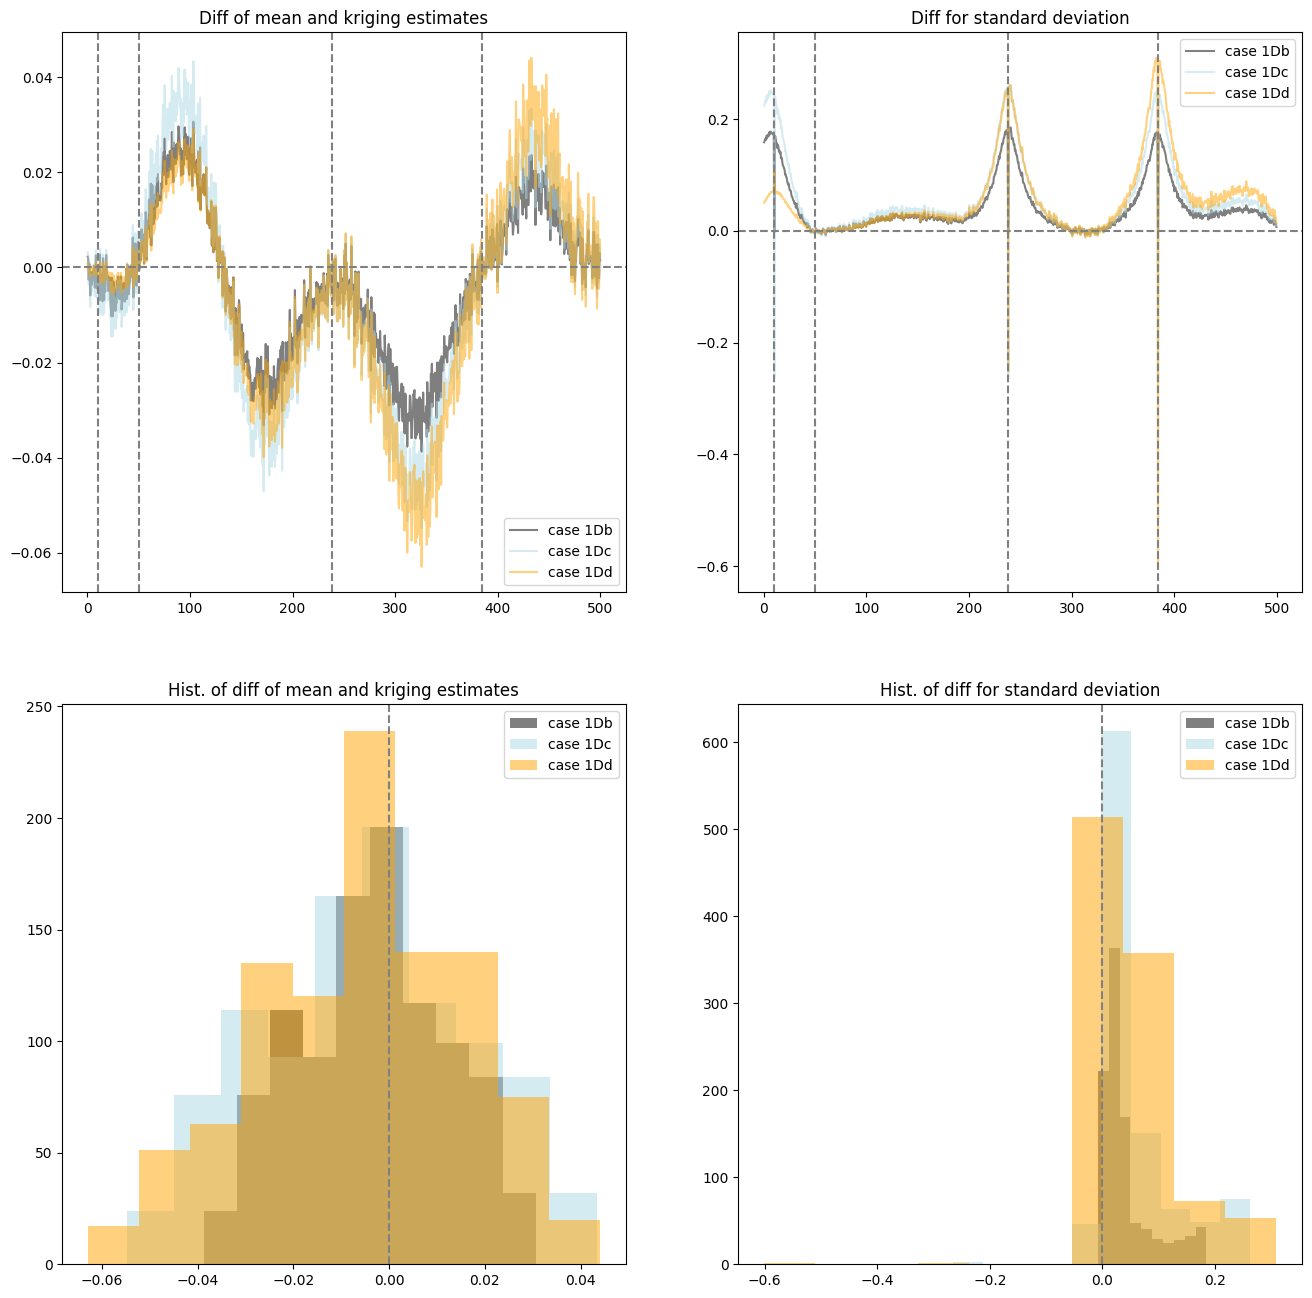

In [32]:
plt.subplots(2, 2, figsize=(16,16)) # 2 x 2 sub-plots

plt.subplot(2, 2, 1) # first sub-plot
plt.plot(xg, sim1Db_mean - krig1Db, c='black', alpha=0.5, label='case 1Db')
plt.plot(xg, sim1Dc_mean - krig1Dc, c='lightblue', alpha=0.5, label='case 1Dc')
plt.plot(xg, sim1Dd_mean - krig1Dd, c='orange', alpha=0.5, label='case 1Dd')
for xx in x:
    plt.axvline(x=xx, c='gray', ls='dashed') # vertical lines at conditioning points
plt.axhline(y=0, c='gray', ls='dashed') # horizontal line at zero
plt.legend()
plt.title('Diff of mean and kriging estimates')

plt.subplot(2, 2, 2) # second sub-plot
plt.plot(xg, sim1Db_std - krig1Db_std, c='black', alpha=0.5, label='case 1Db')
plt.plot(xg, sim1Dc_std - krig1Dc_std, c='lightblue', alpha=0.5, label='case 1Dc')
plt.plot(xg, sim1Dd_std - krig1Dd_std, c='orange', alpha=0.5, label='case 1Dd')
for xx in x:
    plt.axvline(x=xx, c='gray', ls='dashed') # vertical lines at conditioning points
plt.axhline(y=0, c='gray', ls='dashed') # horizontal line at zero
plt.legend()
plt.title('Diff for standard deviation')

plt.subplot(2, 2, 3) # third sub-plot
plt.hist(sim1Db_mean - krig1Db, color='black', alpha=0.5, label='case 1Db')
plt.hist(sim1Dc_mean - krig1Dc, color='lightblue', alpha=0.5, label='case 1Dc')
plt.hist(sim1Dd_mean - krig1Dd, color='orange', alpha=0.5, label='case 1Dd')
plt.axvline(x=0, c='gray', ls='dashed') # vertical line at zero
plt.legend()
plt.title('Hist. of diff of mean and kriging estimates')

plt.subplot(2, 2, 4) # fourth sub-plot
plt.hist(sim1Db_std - krig1Db_std, color='black', alpha=0.5, label='case 1Db')
plt.hist(sim1Dc_std - krig1Dc_std, color='lightblue', alpha=0.5, label='case 1Dc')
plt.hist(sim1Dd_std - krig1Dd_std, color='orange', alpha=0.5, label='case 1Dd')
plt.axvline(x=0, c='gray', ls='dashed') # vertical line at zero
plt.legend()
plt.title('Hist. of diff for standard deviation')
plt.show()